# Domain and Range Filtering Analysis

This notebook contains analyses of the domain and range filtering process. In the end of the notebook the filtering matrices for the validation and testing datasets are generated.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from post_processing_utility import (
    domain_range_filter_triples,
    evaluate_filter
)

In [2]:
# file paths
ONTOLOGY_FILEPATH = "../data/raw_data/ontology--DEV_type=parsed_sorted.nt"
TYPES_FILEPATH = "../data/raw_data/instance-types_inference=transitive_lang=en.ttl"
FILTERED_PROPERTY_TYPES_FILEPATH = "../data/processed_data/filtered_property_types.csv"
VAL_PATH = "../data/processed_data/val.tsv"
TEST_PATH = "../data/processed_data/test.tsv"
UNLABELED_TEST_PATH = "../data/processed_data/test_unlabeled.tsv"
VAL_MATRIX_FILEPATH = "../data/processed_data/val_matrix.csv"
SPECIFIC_TYPES_FILEPATH = "../data/raw_data/instance-types_inference=specific_lang=en.ttl"
TRANSITIVE_TYPES_FILEPATH = "../data/raw_data/instance-types_inference=transitive_lang=en.ttl"
VAL_FILTER_FILEPATH = "../data/processed_data/val_filter.csv"
TEST_FILTER_FILEPATH = "../data/processed_data/test_filter.csv"
UNLABELED_TEST_FILTER_FILEPATH = "../data/processed_data/unlabeled_test_filter.csv"

In [3]:
# load filtered property types
filtered_prop_types = pd.read_csv(FILTERED_PROPERTY_TYPES_FILEPATH)

# load ontology
ontology = pd.read_csv(ONTOLOGY_FILEPATH, sep="> ", header=None, names=["subject", "predicate", "object", "."])
ontology = ontology.drop(columns=".")
# remove labels
ontology = ontology[ontology["predicate"] != "<http://www.w3.org/2000/01/rdf-schema#label"]
# remove leading "<" characters
for col in ontology.columns:
    ontology[col] = ontology[col].str[1:]

# load validation and testing sets
val_triples = pd.read_csv(VAL_PATH, sep="\t", names=["subject", "predicate", "object"])
test_triples = pd.read_csv(TEST_PATH, sep="\t", names=["subject", "predicate", "object"])
unlabeled_test_triples = pd.read_csv(UNLABELED_TEST_PATH, sep="\t", names=["subject", "predicate", "object"])

# load validation set in matrix form
val_df = pd.read_csv(VAL_MATRIX_FILEPATH)

/scratch/slurm_tmpdir/job_23959669/ipykernel_519091/2075427049.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ontology = pd.read_csv(ONTOLOGY_FILEPATH, sep="> ", header=None, names=["subject", "predicate", "object", "."])


## Impact of the upwards extension depth limit

The following plots vizualize the impact of the upwards extension depth limit. Generally, a higher upwards extension depth limit increases recall and lowers precision. At an upwards extension depth limit of 4, there is not much change anymore.

In [4]:
scores_dict = {}

for upwards_extension_depth_limit in range(8):
    val_filter = domain_range_filter_triples(
        triples_df=val_triples,
        specific_types_filepath=SPECIFIC_TYPES_FILEPATH,
        ontology_df=ontology,
        filtered_property_types_df=filtered_prop_types,
        handle_untyped_entities="flexible",
        upwards_extension_depth_limit=upwards_extension_depth_limit,
        upwards_extension_blacklist=[]
    )
    scores_dict[upwards_extension_depth_limit] = evaluate_filter(val_df, val_filter)

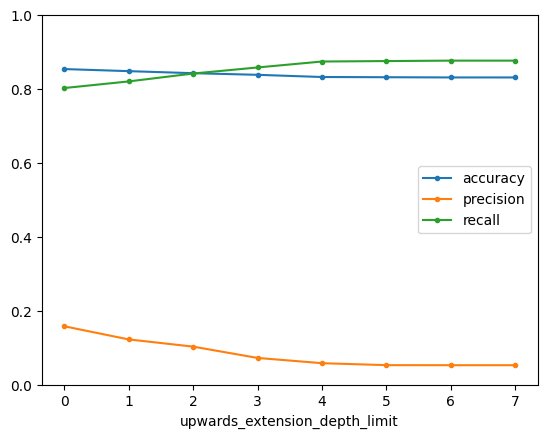

In [5]:
prop = "mean"

accuracy_scores = []
precision_scores = []
recall_scores = []

for upwards_extension_depth_limit, scores in scores_dict.items():
    accuracy_scores.append(scores.loc[prop, "accuracy"])
    precision_scores.append(scores.loc[prop, "precision"])
    recall_scores.append(scores.loc[prop, "recall"])

fig, ax = plt.subplots()

ax.plot(scores_dict.keys(), accuracy_scores, label="accuracy", marker=".")
ax.plot(scores_dict.keys(), precision_scores, label="precision", marker=".")
ax.plot(scores_dict.keys(), recall_scores, label="recall", marker=".")

ax.legend()
ax.set_xlabel("upwards_extension_depth_limit")
ax.set_xticks(np.arange(0, 7.1, 1))
ax.set_yticks(np.arange(0, 1.1, 0.2))

plt.show()

In [6]:
scores_concat = pd.DataFrame()
for upwards_extension_depth_limit, scores in scores_dict.items():
    scores_next = scores.copy()
    scores_next["upwards_extension_depth_limit"] = upwards_extension_depth_limit
    scores_concat = pd.concat([scores_concat, scores_next])
scores_concat = scores_concat.reset_index()
scores_concat = scores_concat.rename(columns={"index": "property"})

scores_concat

,property,accuracy,precision,recall,upwards_extension_depth_limit
0,http://dbpedia.org/ontology/academicAdvisor,0.992951,0.033792,0.965517,0
1,http://dbpedia.org/ontology/academicDiscipline,0.998945,0.229911,0.287709,0
2,http://dbpedia.org/ontology/affiliation,0.781917,0.010747,0.871114,0
3,http://dbpedia.org/ontology/agency,0.737932,0.00059,1.0,0
4,http://dbpedia.org/ontology/aircraftFighter,0.999736,0.347826,1.0,0
...,...,...,...,...,...
2443,http://dbpedia.org/ontology/voice,0.542204,0.008089,0.960616,7
2444,http://dbpedia.org/ontology/writer,0.767607,0.142366,0.978729,7
2445,http://www.w3.org/2000/01/rdf-schema#seeAlso,0.010971,0.010971,1.0,7
2446,http://www.w3.org/2002/07/owl#differentFrom,0.001335,0.001335,1.0,7


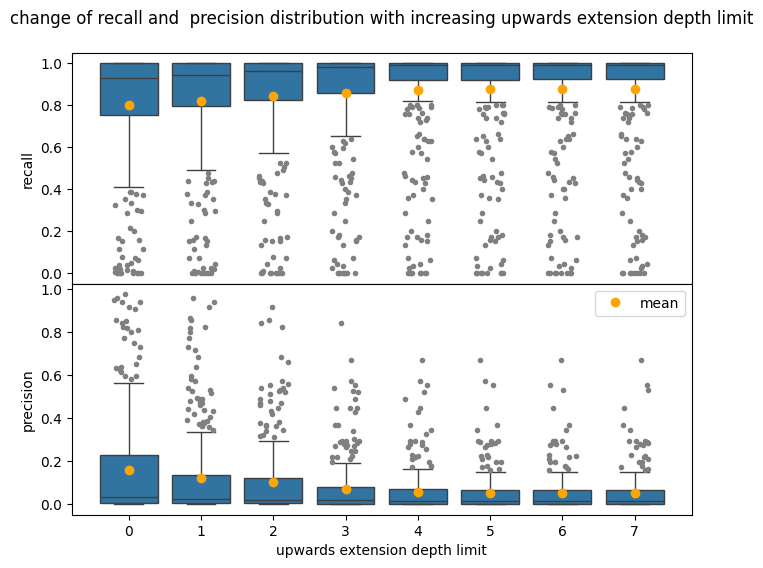

In [7]:
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(8, 6))

flierprops = {
     "marker": ".",
     "markeredgecolor": "gray",
     "markerfacecolor": "gray"
}

sns.boxplot(
    data=scores_concat[scores_concat["property"] != "mean"],
    x="upwards_extension_depth_limit",
    y="recall",
    orient="v",
    flierprops=flierprops,
    ax=axs[0]
)

for l in axs[0].lines:
     if l.get_marker() != '':
          xs = l.get_xdata()
          xs += np.random.uniform(-0.2, 0.2, len(xs))
          l.set_xdata(xs)

axs[0].plot(
    scores_concat[scores_concat["property"] == "mean"]["upwards_extension_depth_limit"],
    scores_concat[scores_concat["property"] == "mean"]["recall"],
    color="orange",
    marker="o",
    linestyle=" ",
    label="mean"
)

#axs[0].legend()
axs[0].set_title("change of recall and  precision distribution with increasing upwards extension depth limit\n")

sns.boxplot(
    data=scores_concat[scores_concat["property"] != "mean"],
    x="upwards_extension_depth_limit",
    y="precision",
    orient="v",
    flierprops=flierprops,
    ax=axs[1]
)

for l in axs[1].lines:
     if l.get_marker() != '':
          xs = l.get_xdata()
          xs += np.random.uniform(-0.2, 0.2, len(xs))
          l.set_xdata(xs)

axs[1].plot(
    scores_concat[scores_concat["property"] == "mean"]["upwards_extension_depth_limit"],
    scores_concat[scores_concat["property"] == "mean"]["precision"],
    color="orange",
    marker="o",
    linestyle=" ",
    label="mean"
)

axs[1].legend()
axs[1].set_xlabel("upwards extension depth limit")

fig.subplots_adjust(hspace=0)

#plt.savefig("recall_precision_upwards_extension.png")
plt.show()

## Examples of relations with low recall values

There are relations where filtering leads to low recall values, even with a high upwards extension depth limit. The following code is concerned with this phenomenon and shows examples of three relations with a very low recall value. First, the list of relations with a recall value of less than 0.8 is printed.

In [8]:
scores_concat[(scores_concat["upwards_extension_depth_limit"] == 4) & (scores_concat["recall"] <= 0.8)].sort_values("recall")

,property,accuracy,precision,recall,upwards_extension_depth_limit
1347,http://dbpedia.org/ontology/highest,0.99713,0.0,0.0,4
1388,http://dbpedia.org/ontology/managerClub,0.967075,0.0,0.0,4
1475,http://dbpedia.org/ontology/river,0.984886,0.0,0.0,4
1321,http://dbpedia.org/ontology/father,0.971961,0.0,0.0,4
1437,http://dbpedia.org/ontology/person,0.99701,0.0,0.0,4
1396,http://dbpedia.org/ontology/mother,0.97242,0.0,0.0,4
1414,http://dbpedia.org/ontology/network,0.983609,0.0,0.0,4
1515,http://dbpedia.org/ontology/territory,0.999794,0.0,0.0,4
1387,http://dbpedia.org/ontology/manager,0.993523,0.008887,0.027174,4
1478,http://dbpedia.org/ontology/routeJunction,0.991741,0.04479,0.036243,4


In [9]:
# filter domain and range restrictions
domain_range = ontology[
    (ontology["predicate"] == "http://www.w3.org/2000/01/rdf-schema#domain")
    | (ontology["predicate"] == "http://www.w3.org/2000/01/rdf-schema#range")
]
domain_range = domain_range.merge(filtered_prop_types, left_on="subject", right_on="filtered_property_types")
domain_range = domain_range.drop(columns="filtered_property_types")

# load specific types
specific_types = pd.read_csv(SPECIFIC_TYPES_FILEPATH, sep=" ", header=None, names=["subject", "predicate", "object", "."])
for col in specific_types.columns:
    specific_types[col] = specific_types[col].str[1:-1]
specific_types = specific_types.drop(columns=["predicate", "."])
specific_types = specific_types.rename(columns={"subject": "entity", "object": "entity_type"})

In [10]:
def analyze_property(property):    
    display(scores_concat[scores_concat["property"] == property])
    
    print("domain and range restrictions")
    display(domain_range[domain_range["subject"] == property])
    pair_sample = val_df[val_df[property] == 1][["subject", "object", property]].sample(1)
    
    print("sampled pair with types")
    display(pair_sample)
    display(specific_types[specific_types["entity"] == pair_sample["subject"].values[0]])
    display(specific_types[specific_types["entity"] == pair_sample["object"].values[0]])
    
    print("ontology excerpt")
    display(ontology[(ontology["subject"] == specific_types[specific_types["entity"] == pair_sample["subject"].values[0]]["entity_type"].values[0]) & (ontology["predicate"] == "http://www.w3.org/2000/01/rdf-schema#subClassOf")])
    display(ontology[(ontology["subject"] == specific_types[specific_types["entity"] == pair_sample["object"].values[0]]["entity_type"].values[0]) & (ontology["predicate"] == "http://www.w3.org/2000/01/rdf-schema#subClassOf")])
    
    print("\ntype distribution subject (domain)")
    display(specific_types.merge(val_df[val_df[property] == 1]["subject"], left_on="entity", right_on="subject")["entity_type"].value_counts())
    
    most_common_subj_type = specific_types.merge(val_df[val_df[property] == 1]["subject"], left_on="entity", right_on="subject")["entity_type"].value_counts().index[0]
    most_common_subj_type_count = specific_types.merge(val_df[val_df[property] == 1]["subject"], left_on="entity", right_on="subject")["entity_type"].value_counts().values[0]
    n_triples = len(val_df[val_df[property] == 1])
    print(most_common_subj_type, most_common_subj_type_count / n_triples)
    
    print("\ntype distribution object (range)")
    display(specific_types.merge(val_df[val_df[property] == 1]["object"], left_on="entity", right_on="object")["entity_type"].value_counts())
        
    most_common_obj_type = specific_types.merge(val_df[val_df[property] == 1]["object"], left_on="entity", right_on="object")["entity_type"].value_counts().index[0]
    most_common_obj_type_count = specific_types.merge(val_df[val_df[property] == 1]["object"], left_on="entity", right_on="object")["entity_type"].value_counts().values[0]
    print(most_common_obj_type, most_common_obj_type_count / n_triples)

### Relation "highest"

The relation "highest" has a recall value of 0 when applying the filter. The reason for that are is the domain restriction, which is not fulfilled in any of the triples of the validation dataset.

In [11]:
analyze_property("http://dbpedia.org/ontology/highest")

,property,accuracy,precision,recall,upwards_extension_depth_limit
123,http://dbpedia.org/ontology/highest,0.999729,0.0,0.0,0
429,http://dbpedia.org/ontology/highest,0.999729,0.0,0.0,1
735,http://dbpedia.org/ontology/highest,0.999708,0.0,0.0,2
1041,http://dbpedia.org/ontology/highest,0.99713,0.0,0.0,3
1347,http://dbpedia.org/ontology/highest,0.99713,0.0,0.0,4
1653,http://dbpedia.org/ontology/highest,0.99713,0.0,0.0,5
1959,http://dbpedia.org/ontology/highest,0.99713,0.0,0.0,6
2265,http://dbpedia.org/ontology/highest,0.99713,0.0,0.0,7


domain and range restrictions


,subject,predicate,object
195,http://dbpedia.org/ontology/highest,http://www.w3.org/2000/01/rdf-schema#domain,http://dbpedia.org/ontology/MountainRange
196,http://dbpedia.org/ontology/highest,http://www.w3.org/2000/01/rdf-schema#range,http://dbpedia.org/ontology/Mountain


sampled pair with types


,subject,object,http://dbpedia.org/ontology/highest
282805,http://dbpedia.org/resource/Laramie_Mountains,http://dbpedia.org/resource/South_Bald_Mountain,1


,entity,entity_type
4216106,http://dbpedia.org/resource/Laramie_Mountains,http://dbpedia.org/ontology/Mountain


,entity,entity_type
6537044,http://dbpedia.org/resource/South_Bald_Mountain,http://dbpedia.org/ontology/Mountain


ontology excerpt


,subject,predicate,object
6973,http://dbpedia.org/ontology/Mountain,http://www.w3.org/2000/01/rdf-schema#subClassOf,http://dbpedia.org/ontology/NaturalPlace


,subject,predicate,object
6973,http://dbpedia.org/ontology/Mountain,http://www.w3.org/2000/01/rdf-schema#subClassOf,http://dbpedia.org/ontology/NaturalPlace



type distribution subject (domain)


entity_type
http://dbpedia.org/ontology/Mountain    152
http://dbpedia.org/ontology/Volcano       1
Name: count, dtype: int64

http://dbpedia.org/ontology/Mountain 0.9934640522875817

type distribution object (range)


entity_type
http://dbpedia.org/ontology/Mountain                141
http://dbpedia.org/ontology/AdministrativeRegion      5
http://dbpedia.org/ontology/Volcano                   3
http://dbpedia.org/ontology/Settlement                1
http://www.w3.org/2002/07/owl#Thing                   1
http://dbpedia.org/ontology/Place                     1
http://dbpedia.org/ontology/Country                   1
Name: count, dtype: int64

http://dbpedia.org/ontology/Mountain 0.9215686274509803


### Relation "river"

The relation "river" shows a similar patter. The domain restriction is never fulfilled. All subjects are of the type "Dam", which is neither a subclass, nor a superordinate class of "Place".

In [12]:
analyze_property("http://dbpedia.org/ontology/river")

,property,accuracy,precision,recall,upwards_extension_depth_limit
251,http://dbpedia.org/ontology/river,0.98595,0.0,0.0,0
557,http://dbpedia.org/ontology/river,0.985434,0.0,0.0,1
863,http://dbpedia.org/ontology/river,0.98493,0.0,0.0,2
1169,http://dbpedia.org/ontology/river,0.98493,0.0,0.0,3
1475,http://dbpedia.org/ontology/river,0.984886,0.0,0.0,4
1781,http://dbpedia.org/ontology/river,0.975946,0.0,0.0,5
2087,http://dbpedia.org/ontology/river,0.975946,0.0,0.0,6
2393,http://dbpedia.org/ontology/river,0.975946,0.0,0.0,7


domain and range restrictions


,subject,predicate,object
377,http://dbpedia.org/ontology/river,http://www.w3.org/2000/01/rdf-schema#domain,http://dbpedia.org/ontology/Place
378,http://dbpedia.org/ontology/river,http://www.w3.org/2000/01/rdf-schema#range,http://dbpedia.org/ontology/River


sampled pair with types


,subject,object,http://dbpedia.org/ontology/river
565206,http://dbpedia.org/resource/Zimapán_Dam,http://dbpedia.org/resource/Moctezuma_River,1


,entity,entity_type
7647003,http://dbpedia.org/resource/Zimapán_Dam,http://dbpedia.org/ontology/Dam


,entity,entity_type
4988589,http://dbpedia.org/resource/Moctezuma_River,http://dbpedia.org/ontology/River


ontology excerpt


,subject,predicate,object
3706,http://dbpedia.org/ontology/Dam,http://www.w3.org/2000/01/rdf-schema#subClassOf,http://dbpedia.org/ontology/Infrastructure


,subject,predicate,object
9034,http://dbpedia.org/ontology/River,http://www.w3.org/2000/01/rdf-schema#subClassOf,http://dbpedia.org/ontology/Stream



type distribution subject (domain)


entity_type
http://dbpedia.org/ontology/Dam    152
Name: count, dtype: int64

http://dbpedia.org/ontology/Dam 1.0

type distribution object (range)


entity_type
http://dbpedia.org/ontology/River      140
http://www.w3.org/2002/07/owl#Thing      9
http://dbpedia.org/ontology/Dam          1
Name: count, dtype: int64

http://dbpedia.org/ontology/River 0.9210526315789473


In [13]:
ontology[(ontology["subject"] == "http://dbpedia.org/ontology/Infrastructure") & (ontology["predicate"] == "http://www.w3.org/2000/01/rdf-schema#subClassOf")]

,subject,predicate,object
5773,http://dbpedia.org/ontology/Infrastructure,http://www.w3.org/2000/01/rdf-schema#subClassOf,http://dbpedia.org/ontology/ArchitecturalStruc...


In [14]:
ontology[(ontology["subject"] == "http://dbpedia.org/ontology/ArchitecturalStructure") & (ontology["predicate"] == "http://www.w3.org/2000/01/rdf-schema#subClassOf")]

,subject,predicate,object
1345,http://dbpedia.org/ontology/ArchitecturalStruc...,http://www.w3.org/2000/01/rdf-schema#subClassOf,http://www.w3.org/2002/07/owl#Thing


In [15]:
ontology[(ontology["subject"] == "http://dbpedia.org/ontology/Place") & (ontology["predicate"] == "http://www.w3.org/2000/01/rdf-schema#subClassOf")]

,subject,predicate,object
7997,http://dbpedia.org/ontology/Place,http://www.w3.org/2000/01/rdf-schema#subClassOf,http://www.w3.org/2002/07/owl#Thing


In [16]:
ontology[(ontology["subject"] == "http://dbpedia.org/ontology/Stream") & (ontology["predicate"] == "http://www.w3.org/2000/01/rdf-schema#subClassOf")]

,subject,predicate,object
10343,http://dbpedia.org/ontology/Stream,http://www.w3.org/2000/01/rdf-schema#subClassOf,http://dbpedia.org/ontology/BodyOfWater


In [17]:
ontology[(ontology["subject"] == "http://dbpedia.org/ontology/BodyOfWater") & (ontology["predicate"] == "http://www.w3.org/2000/01/rdf-schema#subClassOf")]

,subject,predicate,object
2138,http://dbpedia.org/ontology/BodyOfWater,http://www.w3.org/2000/01/rdf-schema#subClassOf,http://dbpedia.org/ontology/NaturalPlace


### Relation "foundedBy"

Finally, the relation "foundedBy" has a range restriction on the type "Agent". Most objects have the type "Person", which is neither a subclass, nor a superordinate class.

In [18]:
analyze_property("http://dbpedia.org/ontology/foundedBy")

,property,accuracy,precision,recall,upwards_extension_depth_limit
109,http://dbpedia.org/ontology/foundedBy,0.774927,0.001204,0.076114,0
415,http://dbpedia.org/ontology/foundedBy,0.70881,0.001621,0.1332,1
721,http://dbpedia.org/ontology/foundedBy,0.70881,0.001621,0.1332,2
1027,http://dbpedia.org/ontology/foundedBy,0.70881,0.001621,0.1332,3
1333,http://dbpedia.org/ontology/foundedBy,0.70881,0.001621,0.1332,4
1639,http://dbpedia.org/ontology/foundedBy,0.70881,0.001621,0.1332,5
1945,http://dbpedia.org/ontology/foundedBy,0.70881,0.001621,0.1332,6
2251,http://dbpedia.org/ontology/foundedBy,0.70881,0.001621,0.1332,7


domain and range restrictions


,subject,predicate,object
173,http://dbpedia.org/ontology/foundedBy,http://www.w3.org/2000/01/rdf-schema#range,http://dbpedia.org/ontology/Agent


sampled pair with types


,subject,object,http://dbpedia.org/ontology/foundedBy
556070,http://dbpedia.org/resource/World_Access_for_t...,http://dbpedia.org/resource/Daniel_Kish,1


,entity,entity_type
7517952,http://dbpedia.org/resource/World_Access_for_t...,http://dbpedia.org/ontology/Organisation


,entity,entity_type
1937765,http://dbpedia.org/resource/Daniel_Kish,http://dbpedia.org/ontology/Person


ontology excerpt


,subject,predicate,object
7692,http://dbpedia.org/ontology/Organisation,http://www.w3.org/2000/01/rdf-schema#subClassOf,http://dbpedia.org/ontology/Agent


,subject,predicate,object
7896,http://dbpedia.org/ontology/Person,http://www.w3.org/2000/01/rdf-schema#subClassOf,http://dbpedia.org/ontology/Animal



type distribution subject (domain)


entity_type
http://dbpedia.org/ontology/Company              1201
http://dbpedia.org/ontology/Organisation          332
http://dbpedia.org/ontology/RecordLabel           245
http://dbpedia.org/ontology/School                 82
http://dbpedia.org/ontology/Newspaper              62
http://dbpedia.org/ontology/Bank                   53
http://dbpedia.org/ontology/LawFirm                10
http://dbpedia.org/ontology/TelevisionStation       9
http://dbpedia.org/ontology/BroadcastNetwork        2
http://dbpedia.org/ontology/College                 1
Name: count, dtype: int64

http://dbpedia.org/ontology/Company 0.6014021031547321

type distribution object (range)


entity_type
http://dbpedia.org/ontology/Person           1226
http://dbpedia.org/ontology/MusicalArtist     146
http://dbpedia.org/ontology/Politician        140
http://www.w3.org/2002/07/owl#Thing           114
http://dbpedia.org/ontology/Company            68
                                             ... 
http://dbpedia.org/ontology/Actor               1
http://dbpedia.org/ontology/SoccerManager       1
http://dbpedia.org/ontology/MilitaryUnit        1
http://dbpedia.org/ontology/Airline             1
http://dbpedia.org/ontology/LawFirm             1
Name: count, Length: 63, dtype: int64

http://dbpedia.org/ontology/Person 0.613920881321983


In [19]:
ontology[(ontology["subject"] == "http://dbpedia.org/ontology/Agent") & (ontology["predicate"] == "http://www.w3.org/2000/01/rdf-schema#subClassOf")]

,subject,predicate,object
904,http://dbpedia.org/ontology/Agent,http://www.w3.org/2000/01/rdf-schema#subClassOf,http://www.w3.org/2002/07/owl#Thing


In [20]:
# load transitive types
transitive_types = pd.read_csv(TRANSITIVE_TYPES_FILEPATH, sep=" ", header=None, names=["subject", "predicate", "object", "."])
for col in transitive_types.columns:
    transitive_types[col] = transitive_types[col].str[1:-1]
transitive_types = transitive_types.drop(columns=["predicate", "."])
transitive_types = transitive_types.rename(columns={"subject": "entity", "object": "entity_type"})

In [21]:
transitive_types[transitive_types["entity"] == "http://dbpedia.org/resource/Kintarō_Hattori"]

,entity,entity_type
25191246,http://dbpedia.org/resource/Kintarō_Hattori,http://dbpedia.org/ontology/Animal
25191247,http://dbpedia.org/resource/Kintarō_Hattori,http://dbpedia.org/ontology/Eukaryote
25191248,http://dbpedia.org/resource/Kintarō_Hattori,http://dbpedia.org/ontology/Species
25191249,http://dbpedia.org/resource/Kintarō_Hattori,http://schema.org/Person
25191250,http://dbpedia.org/resource/Kintarō_Hattori,http://www.ontologydesignpatterns.org/ont/dul/...
25191251,http://dbpedia.org/resource/Kintarō_Hattori,http://www.w3.org/2002/07/owl#Thing
25191252,http://dbpedia.org/resource/Kintarō_Hattori,http://www.wikidata.org/entity/Q19088
25191253,http://dbpedia.org/resource/Kintarō_Hattori,http://www.wikidata.org/entity/Q215627
25191254,http://dbpedia.org/resource/Kintarō_Hattori,http://www.wikidata.org/entity/Q5
25191255,http://dbpedia.org/resource/Kintarō_Hattori,http://www.wikidata.org/entity/Q729


## Get filtering matrices

A filtering matrix is generated for the validation set and for the testing set. The matrices are binary matrices that can be multiplied later with the predictions or scores to filter relations that are not allowed due to types of an entity pair. The matrices have the following properties:

- the upwards extension depth limit is 4
- entities without types are not restricted (they are handled as if they would possess every type)
- any relation that has a recall value below 0.8 on the validation set is not restricted (any entity pair can potentially have this relationship)

In [22]:
# get validation filtering matrix
val_filter = domain_range_filter_triples(
    triples_df=val_triples,
    specific_types_filepath=SPECIFIC_TYPES_FILEPATH,
    ontology_df=ontology,
    filtered_property_types_df=filtered_prop_types,
    handle_untyped_entities="flexible",
    upwards_extension_depth_limit=4,
    upwards_extension_blacklist=[]
)
# set filters to 1 for every relation with recall below 0.8 on validation set
low_recall_props = scores_concat[(scores_concat["upwards_extension_depth_limit"] == 4) & (scores_concat["recall"] <= 0.8)]["property"]
val_filter[low_recall_props] = 1
# save file
val_filter.to_csv(VAL_FILTER_FILEPATH, index=False)

In [23]:
# get testing filtering matrix
test_filter = domain_range_filter_triples(
    triples_df=test_triples,
    specific_types_filepath=SPECIFIC_TYPES_FILEPATH,
    ontology_df=ontology,
    filtered_property_types_df=filtered_prop_types,
    handle_untyped_entities="flexible",
    upwards_extension_depth_limit=4,
    upwards_extension_blacklist=[]
)
# set filters to 1 for every relation with recall below 0.8 on validation set
test_filter[low_recall_props] = 1
# save file
test_filter.to_csv(TEST_FILTER_FILEPATH, index=False)

In [24]:
# get unlabeled testing filtering matrix
unlabeled_test_filter = domain_range_filter_triples(
    triples_df=unlabeled_test_triples,
    specific_types_filepath=SPECIFIC_TYPES_FILEPATH,
    ontology_df=ontology,
    filtered_property_types_df=filtered_prop_types,
    handle_untyped_entities="flexible",
    upwards_extension_depth_limit=4,
    upwards_extension_blacklist=[]
)
# set filters to 1 for every relation with recall below 0.8 on validation set
unlabeled_test_filter[low_recall_props] = 1
# save file
unlabeled_test_filter.to_csv(UNLABELED_TEST_FILTER_FILEPATH, index=False)